In [1835]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy as np
import rich
import pandas as pd

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# close all previous connections to the cluster
Cluster.close_all()

#device_name = "pingu_cluster"
device_name = "loki_cluster"
ip_address = '192.0.2.72'
# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

loki_cluster connected at 192.0.2.72


In [1749]:
# Cluster.close_all()

# cluster.reset()

In [1750]:
cluster.reboot()

In [1836]:
from workers.hardware_utils import SpiDAC
spi = SpiDAC()
dac = spi.create_spi_dac('q13_q14')

Cannot open serial port: /dev/ttyACM0


SerialException: [Errno 2] could not open port /dev/ttyACM0: [Errno 2] No such file or directory: '/dev/ttyACM0'

In [1548]:
import redis
redis_connection = redis.Redis(decode_responses=True)
couplers = [ 'q13_q14']
for coupler in couplers: 
    print(f"Coupler parameters {coupler}:")
    redis_config = redis_connection.hgetall(f"transmons:{coupler}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")

Coupler parameters q13_q14:
parking_current: -0.00075


In [1832]:
coupler = 'q13_q14'
transmon_parameter = 'parking_current'
for coupler in couplers: 
    redis_connection.hset(f"transmons:{coupler}", f"{transmon_parameter}", -775e-6)
parking_current = float(redis_connection.hget(f'transmons:{coupler}', 'parking_current'))
parking_current

-0.000775

In [1833]:
# spi.set_dacs_zero()

In [1834]:
spi.set_dac_current(dac, parking_current)

PortNotOpenError: ('Attempting to use a port that is not open', 'setting loki_rack_module1_dac2_current to -0.000775')

In [1825]:
!python reset_redis.py all

 remove_node = 'all'


In [1826]:
# !python reset_redis.py 'resonator_spectroscopy'
# !python reset_redis.py 'qubit_01_spectroscopy_multidim'
# !python reset_redis.py 'rabi_oscillations'
# !python reset_redis.py 'ramsey_correction'
# !python reset_redis.py 'motzoi_parameter'
# !python reset_redis.py 'n_rabi_oscillations'
# !python reset_redis.py 'resonator_spectroscopy_1'
# !python reset_redis.py 'qubit_12_spectroscopy_multidim'
# !python reset_redis.py 'rabi_oscillations_12'
# !python reset_redis.py 'ramsey_correction_12'
# !python reset_redis.py 'resonator_spectroscopy_2'
# !python reset_redis.py 'coupler_spectroscopy'
# !python reset_redis.py 'cz_chevron'
# !python reset_redis.py 'cz_calibration'
# !python reset_redis.py 'cz_calibration_ssro'
# !python reset_redis.py 'ro_frequency_optimization_gef'
# !python reset_redis.py 'ro_amplitude_optimization_gef'

In [1831]:
!python workers/calibration_supervisor.py

clusterA_module13_att:40dB
clusterA_module17_att:16dB
2023-12-31 14:17:52,762 ◆ calibration_supervisor.py ◆ Starting System Calibration
╔═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╗
║ Qubits: 2                                                                                                                                                                                                   ║
║↪ resonator_spectroscopy                                                                                                                                                                                     ║
║           ↪ qubit_01_spectroscopy_multidim                                                                                                                                                                  ║
║                          ↪ rab

# CZ_calibration Data Broswing

In [1828]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
# name = '20231226-175522-736-99b290-cz_calibration_ssro'

from os import listdir
date = '20231231'
path = f'data_directory/{date}'
names = np.sort(listdir(path))
name = names[-1]
name = '20231231-121410-941-404eaf-cz_calibration_ssro'
print(name)
dp = f'data_directory/{date}/{name}/dataset.hdf5'
ds = load_dataset(dp)

20231231-121410-941-404eaf-cz_calibration_ssro


assignment = 0.6695963541666666
assignment = 0.6549479166666666


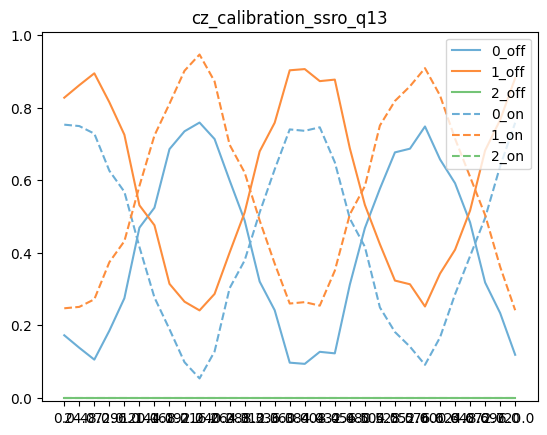

assignment = 0.6761067708333334
assignment = 0.6494140625


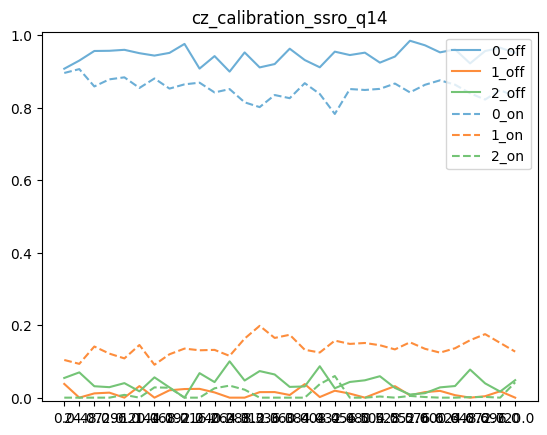

In [1829]:
import numpy as np
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.optimize import minimize
from numpy.linalg import inv

def mitigate(v,cm_inv):
    u = np.dot(v,cm_inv)
    # print(u,np.sum(u))
    def m(t):
        return norm(u-np.array(t))
    def con(t):
        return t[0]+t[1]+t[2]-1
    cons = ({'type': 'eq', 'fun': con},
            {'type': 'ineq', 'fun': lambda t: t[0]},
            {'type': 'ineq', 'fun': lambda t: t[1]},
            {'type': 'ineq', 'fun': lambda t: t[2]})
    result = minimize(m, v, method='SLSQP', constraints=cons)
    w = np.abs(np.round(result.x,10))
    # print(w)
    return w

dataset = ds
for qubit in ['q13','q14']:
# qubit = 'q13'
    data_var = f'y{qubit}'

    for coord in dataset.coords:
        if f'control_ons{qubit}' in str(coord):
            sweep_coord = coord
        elif f'ramsey_phases{qubit}' in str(coord):
            state_coord = coord
        elif 'shot' in str(coord):
            shot_coord = coord

    independents = dataset[state_coord].values[:-3]
    calibs = dataset[state_coord].values[-3:]
    sweeps = dataset.coords[sweep_coord]
    shots = len(dataset[shot_coord].values)
    magnitudes = []
    for indx, _ in enumerate(sweeps):
        # indx = 0
        # print(f'{indx = }')
        # print(f'{ro_amplitude.values = }')
        y = np.repeat(calibs,shots)
        IQ_complex = np.array([])
        for state, _ in enumerate(calibs):
            IQ_complex_0 = dataset[data_var].isel({sweep_coord:indx,state_coord:-3+state})
            IQ_complex = np.append(IQ_complex,IQ_complex_0)
        # IQ = np.array([I,Q]).T
        IQ = IQ_complex.reshape(-1,2)
        lda = LinearDiscriminantAnalysis(solver = "svd", store_covariance=True)
        # breakpoint()
        # print(IQ)
        cla = lda.fit(IQ,y)
        y_pred = cla.predict(IQ)

        cm = confusion_matrix(y,y_pred)
        cm_norm = confusion_matrix(y,y_pred,normalize='true')
        cm_inv = inv(cm_norm)
        assignment = np.trace(cm_norm)/len(calibs)
        print(f'{assignment = }')

        # disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
        # disp.plot()
        # plt.show()

        raw_data = dataset[data_var].isel({sweep_coord:indx}).values
        raw_shape = raw_data.shape
        data_y_pred = cla.predict(raw_data.reshape(-1,2))
        data_y_pred = np.transpose(data_y_pred.reshape(raw_shape[:-1]))
        # print(data_y_pred.shape)
        # print(data_y_pred)
        data_res_shape = list(data_y_pred.shape[:-1])
        data_res_shape.append(len(calibs))

        data_res = np.array([])
        for index_2, sweep_2 in enumerate(data_y_pred):
            uniques, counts = np.unique(sweep_2, return_counts=True)
            raw_prob = counts/len(sweep_2)
            # print(raw_prob)
            mitigate_prob = mitigate(raw_prob,cm_inv)
            data_res = np.append(data_res,mitigate_prob)
            # print(mitigate_prob)
        data_res = data_res.reshape(data_res_shape)
        magnitudes.append(data_res)
    magnitudes = np.array(magnitudes)
    marker = ['-','--']
    legend = ['off','on']
    x = range(4)
    # colors = plt.get_cmap('RdBu_r')(np.linspace(0.2, 0.8, len(x)))
    # colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.8, 2))
    colors = plt.get_cmap('tab20c')
    for index,magnitude in enumerate(magnitudes):
        plt.plot(independents,magnitude[:-3,0],f'{marker[index]}',c=colors(1),label=f'0_{legend[index]}')
        plt.plot(independents,magnitude[:-3,1],f'{marker[index]}',c=colors(1+4),label=f'1_{legend[index]}')
        plt.plot(independents,magnitude[:-3,2],f'{marker[index]}',c=colors(1+4*2),label=f'2_{legend[index]}')
        plt.ylim(-0.01,1.01)
        plt.legend(loc = 'upper right')
        # plt.xlim(np.min(independents),np.max(independents))
    plt.title(f'cz_calibration_ssro_{qubit}')
    plt.savefig(f'{path}/{name}/cz_calibration_ssro_{qubit}.png')
    plt.show()

In [1830]:
colors = plt.get_cmap('RdYlGn')(np.linspace(0.2, 0.8, 2))
print(colors[1])

[0.4        0.74117647 0.38823529 1.        ]


In [1780]:
print(colors)

In [1770]:
magnitudes[:,:-3,0]

array([[0.95328687, 1.        , 0.97489076, 0.98119963, 0.95625897,
        0.97826324, 0.97291053, 0.99195332, 0.96982418, 1.        ,
        0.95966036, 0.95933393, 0.95112348, 0.99720885, 0.9554089 ,
        0.98439055, 0.93278169, 0.99826859, 1.        , 0.98239483,
        0.96128176, 0.93895345, 0.96381981, 0.98376218, 0.91227093,
        0.95988543, 0.95262008, 0.96938914, 0.97041375, 0.9554089 ,
        0.9835155 ],
       [0.57196983, 0.62658829, 0.55304507, 0.57090802, 0.56681152,
        0.57872153, 0.57781171, 0.55342449, 0.55171574, 0.56521868,
        0.57140295, 0.55482668, 0.53874458, 0.57462524, 0.63326385,
        0.51777045, 0.58888649, 0.56366518, 0.59009961, 0.56085663,
        0.57303289, 0.56764709, 0.57985954, 0.55793859, 0.61847084,
        0.53434505, 0.56776091, 0.55990903, 0.54272767, 0.61843364,
        0.58206046]])

In [ ]:
# %matplotlib inline
# qubit = 'q13'
# ds0 = ds[f'y{qubit}']
# ds0 = (ds0.values).reshape(1024*34*2,2)
# # print(ds0)
# plt.plot(ds0[:,0],ds0[:,1],'.r')
# plt.show()

# qubit = 'q14'
# ds0 = ds[f'y{qubit}']
# ds0 = (ds0.values).reshape(1024*34*2,2)
# # print(ds0)
# plt.plot(ds0[:,0],ds0[:,1],'.b')
# plt.show()

In [ ]:
# %matplotlib inline
# qubit = 'q13'

# ds0 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c0',control_onsq13=False )
# ds1 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c1',control_onsq13=False )
# ds2 = ds[f'y{qubit}'].sel(ramsey_phasesq13='c2',control_onsq13=False )

# plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
# plt.show()

# %matplotlib inline
# qubit = 'q14'

# ds0 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c0',control_onsq14=False )
# ds1 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c1',control_onsq14=False )
# ds2 = ds[f'y{qubit}'].sel(ramsey_phasesq14='c2',control_onsq14=False )

# plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
# plt.show()

In [ ]:
# nested join using join()
my_string = ",".join(str(element) for element in list(cm_inv.flatten()))
print(my_string)

In [ ]:
my_list = my_string.split(",")
size = int(len(my_list)**0.5)
my_list = np.array([float(i) for i in my_list]).reshape(size,size)

print(my_list)

[[ 1.36277471 -0.15911288 -0.20366183]
 [-0.29625934  1.42344841 -0.12718907]
 [-0.14756231 -0.02953404  1.17709634]]


# ro_amplitude_optimization_gef Data Broswing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import load_dataset
from workers.post_processing_worker import Multiplexed_Analysis
# dp = r"data_directory/20231106/20231106-155442-755-1ff0de-cz_chevron/dataset.hdf5"
name = '20231225-165135-093-09e0cd-cz_calibration_ssro'
dp = f'data_directory/{name[:8]}/{name}/dataset.hdf5'

In [ ]:
ds = load_dataset(dp)
ds

<xarray.Dataset>
Dimensions:           (shot: 1024, ramsey_phasesq14: 34, control_onsq14: 2,
                       ReIm: 2, ramsey_phasesq13: 34, control_onsq13: 2)
Coordinates:
  * shot              (shot) int32 0 1 2 3 4 5 ... 1018 1019 1020 1021 1022 1023
  * ramsey_phasesq14  (ramsey_phasesq14) object '0.0' '24.0' '48.0' ... 'e' 'f'
  * ramsey_phasesq13  (ramsey_phasesq13) object '0.0' '24.0' '48.0' ... 'e' 'f'
  * control_onsq14    (control_onsq14) bool False True
  * control_onsq13    (control_onsq13) bool False True
Dimensions without coordinates: ReIm
Data variables:
    yq14              (shot, ramsey_phasesq14, control_onsq14, ReIm) float64 ...
    yq13              (shot, ramsey_phasesq13, control_onsq13, ReIm) float64 ...
Attributes:
    name:     cz_calibration_ssro
    tuid:     20231225-165135-093

0.091


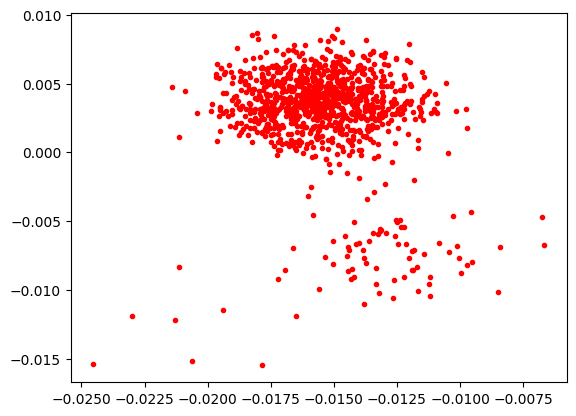

In [ ]:
%matplotlib inline
# select the data with ro_amplitudesq12 = 0.051
amp = ds.ro_amplitudesq12.values[5]
# for amp in ds.ro_amplitudesq12.values:
print(amp)
qubit = 'q130'
ds0 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 0 )
ds1 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 1 )
ds2 = ds[f'y{qubit}'].sel(ro_amplitudesq13=amp ,state = 2 )
# ds0 = (ds0.values).reshape(4096*3,2)
# ds1 = (ds1.values).reshape(4096*3,2)
# ds2 = (ds2.values).reshape(4096*3,2)

cut0 = 0
cut1 = 15
plt.plot(ds0[:,0].values,ds0[:,1].values,'.r')
# plt.plot(ds1[:,0].values,ds1[:,1].values,'.b')
# plt.plot(ds1[cut0::cut1,0].values,ds1[cut0::cut1,1].values,'*')
# plt.plot(ds2[:,0].values,ds2[:,1].values,'.g')
plt.show()

assignment = 0.8388671875


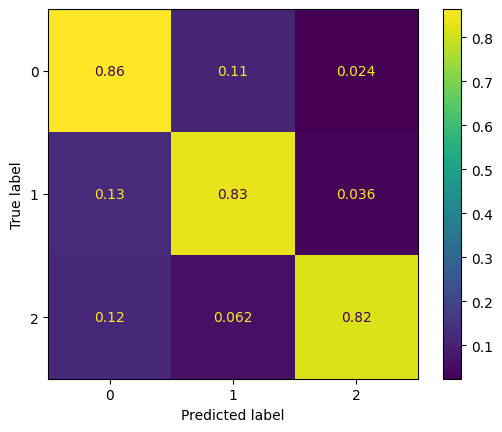

In [ ]:
import numpy as np
import redis
import xarray as xr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

dataset = ds
qubit = 'q12'
data_var = f'y{qubit}0'

for coord in dataset.coords:
    if f'amplitudes{qubit}' in str(coord):
        amplitude_coord = coord
    elif 'state' in str(coord):
        state_coord = coord
    elif 'shot' in str(coord):
        shot_coord = coord

independents = dataset[state_coord].values
amplitudes = dataset.coords[amplitude_coord]
shots = len(dataset[shot_coord].values)
fit_results = {}
# for indx, ro_amplitude in enumerate(amplitudes):
indx = 3
# print(f'{indx = }')
# print(f'{ro_amplitude.values = }')
y = np.repeat(independents,shots)
IQ_complex = np.array([])
for state in independents:
    IQ_complex_0 = dataset[data_var].isel({amplitude_coord:[indx],state_coord:state})
    IQ_complex = np.append(IQ_complex,IQ_complex_0)
# I = IQ_complex.real.flatten()
# Q = IQ_complex.imag.flatten()
# IQ = np.array([I,Q]).T
IQ = IQ_complex.reshape(-1,2)
lda = LinearDiscriminantAnalysis(solver = "svd", store_covariance=True)
# breakpoint()
# print(IQ)
y_pred = lda.fit(IQ,y).predict(IQ)

cm = confusion_matrix(y,y_pred)
cm_norm = confusion_matrix(y,y_pred,normalize='true')
# assignment = 1 - 1/2 * (err_wr_0 + err_wr_1)
assignment = np.trace(cm_norm)/len(independents)
print(f'{assignment = }')

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm)
disp.plot()
plt.show()

In [ ]:
from numpy.linalg import inv
print(cm_norm)
cm_inv = inv(cm_norm)
print(cm_inv)
print(np.dot(cm_inv,cm_norm))

[[0.86425781 0.11132812 0.02441406]
 [0.12890625 0.83496094 0.03613281]
 [0.12011719 0.0625     0.81738281]]
[[ 1.18425448 -0.1557683  -0.02848618]
 [-0.17588313  1.22477137 -0.04888825]
 [-0.16058158 -0.0707597   1.23134128]]
[[ 1.00000000e+00 -4.40186082e-17 -8.83285957e-18]
 [ 3.78725371e-17  1.00000000e+00  8.53131584e-18]
 [ 2.47198095e-17  0.00000000e+00  1.00000000e+00]]


In [ ]:
v = [0.87,0.11,1-0.87-0.11]
print(v)

[0.87, 0.11, 0.020000000000000004]


In [ ]:
def mitigated(v,a0,a1):
    return np.dot(cm_inv,v)-[a0,a1,1-a0-a1]
res = minimize(mitigated, v)


TypeError: mitigated() missing 2 required positional arguments: 'a0' and 'a1'

In [ ]:
a,b = 0.8,0.1
v = [a,b,1-a-b]
u = np.dot(cm_inv,v)
print(v,u,np.sum(u))

[0.8, 0.05, 0.14999999999999997] [ 0.93534224 -0.08680117  0.05269794] 0.9012390169552309


In [ ]:
# Define the function to be minimized
from scipy.linalg import norm
def m(t):
    return norm(u-np.array(t))

In [ ]:
# Define the constraints
def con(t):
   return t[0]+t[1]+t[2]-1
# Define the constraints in the form required by the minimize function
cons = ({'type': 'eq', 'fun': con},
        {'type': 'ineq', 'fun': lambda t: t[0]},
        {'type': 'ineq', 'fun': lambda t: t[1]},
        {'type': 'ineq', 'fun': lambda t: t[2]})

In [ ]:
from scipy.optimize import minimize
result = minimize(m, v, method='SLSQP', constraints=cons)
print(np.abs(np.round(result.x,10)))

[0.94132282 0.         0.05867718]


In [ ]:
cm_inv

array([[ 1.18425448, -0.1557683 , -0.02848618],
       [-0.17588313,  1.22477137, -0.04888825],
       [-0.16058158, -0.0707597 ,  1.23134128]])

In [ ]:
# nested join using join()
my_string = ",".join(str(element) for element in list(cm_inv.flatten()))
print(my_string)

1.1842544812150915,-0.15576829843331808,-0.028486182781773627,-0.1758831264569345,1.2247713733537886,-0.04888824689685401,-0.1605815783706242,-0.07075969795381643,1.2313412763244407


In [ ]:
my_list = my_string.split(",")
size = int(len(my_list)**0.5)
my_list = np.array([float(i) for i in my_list]).reshape(size,size)

print(my_list)

[[ 1.18425448 -0.1557683  -0.02848618]
 [-0.17588313  1.22477137 -0.04888825]
 [-0.16058158 -0.0707597   1.23134128]]


# Redis Parameters

In [1529]:
import redis
redis_connection = redis.Redis(decode_responses=True)
node = 'cz_chevron'
qubits = ['q13']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"cs:{qubit}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")

Qubit parameters q13:
tof: not_calibrated
resonator_spectroscopy: calibrated
resonator_spectroscopy_1: calibrated
resonator_spectroscopy_2: calibrated
ro_frequency_optimization: not_calibrated
ro_amplitude_optimization: not_calibrated
SSRO: not_calibrated
qubit_01_spectroscopy_pulsed: not_calibrated
ramsey_correction: calibrated
qubit_12_spectroscopy_pulsed: not_calibrated
ramsey_correction_12: calibrated
rabi_oscillations: calibrated
n_rabi_oscillations: calibrated
motzoi_parameter: calibrated
rabi_oscillations_12: calibrated
randomized_benchmarking: not_calibrated
state_discrimination: not_calibrated
T1: not_calibrated
XY_crosstalk: not_calibrated
punchout: not_calibrated
cz_chevron: calibrated
cz_calibration: calibrated
qubit_01_spectroscopy_multidim: calibrated
coupler_spectroscopy: not_calibrated
coupler_resonator_spectroscopy: not_calibrated
ro_frequency_optimization_gef: calibrated
two_tone_multidim: not_calibrated
qubit_12_spectroscopy_multidim: calibrated
ro_amplitude_optimiza

In [1520]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = ['q13','q14']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    for key, value in redis_config.items():
        print(f"{key}: {value}")
    # print(redis_config['cz_pulse_frequency'])
    # print(redis_config['cz_pulse_duration'])

Qubit parameters q13:
mw_pulse_duration: 2e-08
dc_flux: nan
spec_ampl_optimal: 0.0006
ro_acq_delay: 2.2e-07
spec_ampl_default: 0.0003
spec_pulse_duration: 5e-06
inv_cm_opt: 1.1059881797266866,-0.12305806892178624,0.01706988919509955,-0.14686323764927772,1.4690205594712584,-0.32215732182198054,-0.08026648456616994,-0.3166048825695681,1.396871367135738
Ql: 10973.772061927006
ro_acq_integration_time: 2.5e-06
Ql_1: 9577.569636001048
cz_pulse_amplitude: nan
parking_current: nan
spec_ampl_12_optimal: 0.0006
discriminator: nan
ro_pulse_duration: 3e-06
spec_amp: nan
ro_freq_opt: 6688049321.558435
ro_ampl: nan
ro_pulse_amp: 0.02
selectivity: nan
ro_ampl_opt: 0.031000000000000003
resonator_minimum_1: 6688049321.558435
resonator_minimum: 6688301321.558435
att: 0
edge_group: nan
cz_pulse_duration: 2e-07
freq_12: 3344368945.30437
cz_phase: 162.73823195740903
artificial_detuning: 3000000.0
dc_flux_0: nan
init_duration: 0.0006
fidelity: nan
mw_ef_amp180: 0.16987174153378343
ro_freq_1: 6688079059.0376

In [1526]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q13','q14']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
        # print(f"{key}: {value}")
    print(redis_config['cz_pulse_frequency'])
    print(redis_config['cz_pulse_amplitude'])

Qubit parameters q13:
448900000.0
nan
Qubit parameters q14:
448900000.0
nan


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q12','q13','q14','q15']
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")

Qubit parameters q12:
3366985350.8172603
3173745577.505435
Qubit parameters q13:
3583392807.127604
3344617330.110173
Qubit parameters q14:
3333262125.7570114
3133075732.4790416
Qubit parameters q15:
3872762251.21086
3631663526.956842


# Save VNA values

In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q12','q13','q14','q15']
qubit_freq_01_list,qubit_freq_ro_list,qubit_freq_12_list = {},{},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['ro_freq'])
    print(redis_config['freq_01'])
    print(redis_config['freq_12'])
    qubit_freq_ro_list[qubit] = redis_config['ro_freq']
    qubit_freq_01_list[qubit] = redis_config['freq_01']
    qubit_freq_12_list[qubit] = redis_config['freq_12']

Qubit parameters q12:
6606921525.748695
3367033969.74316
3174143769.9106717
Qubit parameters q13:
6688305934.245103
3584439595.342654
3343546801.86418
Qubit parameters q14:
6331389462.314763
3333635940.6319256
3133115800.4734387
Qubit parameters q15:
6933732844.833205
3872743173.062422
3631686732.52316


In [ ]:
for qubit in qubits:
    d = float(qubit_freq_ro_list[qubit]) - (float(qubit_freq_01_list[qubit])+float(qubit_freq_12_list[qubit]))
    print(d/1e6)

65.74378609486389
-239.6804629617319
-135.36227879060078
-570.6970607523765


In [ ]:
import redis
redis_connection = redis.Redis(decode_responses=True)
qubits = [ 'q11','q12','q13','q14','q15']
qubit_freq_01_list,qubit_freq_ro_list,qubit_freq_12_list = {},{},{}
for qubit in qubits: 
    print(f"Qubit parameters {qubit}:")
    redis_config = redis_connection.hgetall(f"transmons:{qubit}")
    # Print the redis config line by line
    # for key, value in redis_config.items():
    #     print(f"{key}: {value}")
    print(redis_config['ro_freq'])
    # print(redis_config['freq_01'])
    # print(redis_config['freq_12'])
    qubit_freq_ro_list[qubit] = redis_config['ro_freq']
    # qubit_freq_01_list[qubit] = redis_config['freq_01']
    # qubit_freq_12_list[qubit] = redis_config['freq_12']
    # print(float(redis_config['freq_12'])-float(redis_config['freq_01']))

Qubit parameters q11:
6933046236.676112
Qubit parameters q12:
6605630877.985153
Qubit parameters q13:
6687608483.810531
Qubit parameters q14:
6330507281.392011
Qubit parameters q15:
6933000688.562917


In [ ]:
from config_files.VNA_values import VNA_resonator_frequencies, VNA_qubit_frequencies, VNA_f12_frequencies
for qubit in qubits:
    VNA_resonator_frequencies[qubit] = float(qubit_freq_ro_list[qubit])
    VNA_qubit_frequencies[qubit] = float(qubit_freq_01_list[qubit])
    VNA_f12_frequencies[qubit] = float(qubit_freq_12_list[qubit])
# rewrite the VNA_values.py file
with open('config_files/VNA_values.py', 'w') as f:
    f.write(f"VNA_resonator_frequencies = {VNA_resonator_frequencies}\n")
    f.write(f"VNA_qubit_frequencies = {VNA_qubit_frequencies}\n")
    f.write(f"VNA_f12_frequencies = {VNA_f12_frequencies}\n")

In [ ]:
import numpy as np
print(VNA_resonator_frequencies)
print(VNA_qubit_frequencies)
print(VNA_f12_frequencies)
anahar = (np.array(list(VNA_f12_frequencies.values()))-np.array(list(VNA_qubit_frequencies.values()))) / 1e6
print(anahar)

{'q11': 6934572785.610347, 'q12': 6606753684.764918, 'q13': 6688313321.558435, 'q14': 6331351280.923618, 'q15': 6933698139.447023, 'q16': 6491000000.0, 'q17': 7059000000.0, 'q18': 6712000000.0, 'q19': 6818000000.0, 'q20': 6494000000.0, 'q21': 6751000000.0, 'q22': 6477000000.0, 'q23': 7052000000.0, 'q24': 6583000000.0, 'q25': 6853000000.0}
{'q11': 3714895945.38633, 'q12': 3366961177.836733, 'q13': 3585016857.038436, 'q14': 3334060710.6204877, 'q15': 3872936707.280074, 'q16': 3189000000.0, 'q17': 3932000000.0, 'q18': 3254000000.0, 'q19': 3921000000.0, 'q20': 3333000000.0, 'q21': 3773000000.0, 'q22': 3326000000.0, 'q23': 3911000000.0, 'q24': 3271000000.0, 'q25': 4009000000.0}
{'q11': 3480306890.6912713, 'q12': 3174059567.052809, 'q13': 3343386697.937837, 'q14': 3133224381.376709, 'q15': 3631763299.7146664, 'q16': 2993000000.0, 'q17': 3699000000.0, 'q18': 3154000000.0, 'q19': 3682000000.0, 'q20': 3233000000.0, 'q21': 3542000000.0, 'q22': 3131000000.0, 'q23': 3674000000.0, 'q24': 3171000000

In [ ]:
(3585016857+3334060710-(3585016857+3343386697))/1e6

-9.325987

In [ ]:
(3585016857+3334060710-(3133224381+3334060710))/1e6

451.792476

In [ ]:
VNA_resonator_frequencies = {'q11': 6934572785.610347, 'q12': 6606753684.764918, 'q13': 6688313321.558435, 'q14': 6331351280.923618, 'q15': 6933698139.447023, 'q16': 6491000000.0, 'q17': 7059000000.0, 'q18': 6712000000.0, 'q19': 6818000000.0, 'q20': 6494000000.0, 'q21': 6751000000.0, 'q22': 6477000000.0, 'q23': 7052000000.0, 'q24': 6583000000.0, 'q25': 6853000000.0}
VNA_qubit_frequencies = {'q11': 3714895945.38633, 'q12': 3366961177.836733, 'q13': 3585016857.038436, 'q14': 3334060710.6204877, 'q15': 3872936707.280074, 'q16': 3189000000.0, 'q17': 3932000000.0, 'q18': 3254000000.0, 'q19': 3921000000.0, 'q20': 3333000000.0, 'q21': 3773000000.0, 'q22': 3326000000.0, 'q23': 3911000000.0, 'q24': 3271000000.0, 'q25': 4009000000.0}
VNA_f12_frequencies = {'q11': 3480306890.6912713, 'q12': 3174059567.052809, 'q13': 3343386697.937837, 'q14': 3133224381.376709, 'q15': 3631763299.7146664, 'q16': 2993000000.0, 'q17': 3699000000.0, 'q18': 3154000000.0, 'q19': 3682000000.0, 'q20': 3233000000.0, 'q21': 3542000000.0, 'q22': 3131000000.0, 'q23': 3674000000.0, 'q24': 3171000000.0, 'q25': 3770000000.0}
